## Keras - Clean Project Workflow


### Aim:


Aim of this notebook is to show an example of clean workflow Computer Vision project/competition in Keras. 

### Workflow:


Workflow can be interpreted as following steps:
1. Dataset initialization (if needed): this step is usually required in case where training samples are separated from from their labels or there is additional information about the samples of a different format. This is the case here, __depth__ is an additional feature that is separate from training images and is thus provided in DataFrame format. For easy integration between the depth and images, each sample has a unique ID. By those IDs images can be connected with their masks and depth added on top of that.
2. Data loading/processing: set of operations preparing the data for model-ingestible format. Each sample is loaded as image and appended to a list, same happends with masks. Afterwards, dimensions are expanded (if needed), because 2D Convolutional CNN require input samples of dimensionality (HxWxC - height x width x channels) and OpenCV loads grayscale images as (HxW) 2D arrays.
3. Data is normalized to 0-1 input range. When loaded in OpenCV, grayscale images come in range between 0 and 255. Networks usually converge quicker if data is in 0-1 range. It is also important to keep the values range the same for images and masks (feeding the model with 0-255 images and 0-1 masks is not recommended).
4. Data is split into training and validation subsets. For this competition, salt coverage is the basis of the split. Then, a stratified split is performed in order to avoid significant discrepancy in distribution between training and validation sets. This could potentially harm model performance or at least skew the validation metric results.
5. Model definition and training. A lot more about this can be read either in segmentation papers, solutions from past competition or discussions part itself :). One major principle to keep in mind - segmentation model output must be of the same shape as was the input! 
6. Prediction with trained model.
7. Predictions processing. This can be done in different ways, depending on the final goal. For this competition, predictions and encoded with Run Length Encoding in order to compress their size (raw masks predictions would weight around a GB). Method of processing is very important, as it may require a specific approach to final predictions preparation. In case of RLE, one have to make sure that predictions are scaled (or unpadded) to original image size. Otherwise, RLE will encode wrong pixels and thus final submission score will be low. 

In [1]:
import gc
import glob
import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from keras.callbacks import *
from keras.models import load_model
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Define SaltParser

The first question most probably would be - __why create and use parser like this one?__

In Machine Learning, you usually can tune two things: models and data. Each parameter can influence the final score, so it's good to know what kind of parameters are used for each run and it's even better to design the pipeline in a way that will minimize potential errors. 

When a certain operation will be used many times but with different parameters, it is good to parameterize it and just call with chosen parameters. Besides, having functions for processing in one place makes it easier to spot mistakes. This is even more important when you perform an operation in different parts of the pipeline. Then, making sure that all functions are doing the same (for example using different types of padding for training and prediction certainly would not be a good idea!).

In [2]:
class SaltParser(object):

    '''
    Parser for Salt Competition.
    
    # Arguments:
        data_src: directory containing data
        image_size: tuple specifying final image size
        pad_images: whether images should be padded or resized
        grayscale: whether to load images as grayscale
        load_test_data: whether to load test data
    '''

    def __init__(self,
                 data_src='data/salt/',
                 image_size=(128, 128),
                 pad_images=False,
                 grayscale=True,
                 load_test_data=True):

        self.data_src = data_src
        self.image_size = image_size
        self.pad_images = pad_images
        self.grayscale = grayscale
        self.load_test_data = load_test_data

        self.train_df = None
        self.test_df = None
        self.padding_pixels = None

        self.X_train = []
        self.y_train = []
        self.X_test = []

        self.orig_image_size = (101, 101)
        

    def load_csv_data(self):
        
        '''
        Initialize processing by loading .csv files.
        After loading, train_df and test will have column 'id' and corresponding
        'z' for depth
        '''

        train_df = pd.read_csv(f'{self.data_src}train.csv', usecols=[0], index_col='id')
        depths_df = pd.read_csv(f'{self.data_src}depths.csv', index_col='id')
        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    def load_img_data(self):
        
        '''
        Load images and masks from training set. Can only be executed after load_csv_data()
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        '''

        print('Loading training set.')

        for i in tqdm_notebook(self.train_df.index):
            img_src = f'{self.data_src}train/images/{i}.png'
            mask_src = f'{self.data_src}train/masks/{i}.png'
            
            if self.grayscale:
                img_temp = cv2.imread(img_src, 0)
            else:
                img_temp = cv2.imread(img_src)
                
            mask_temp = cv2.imread(mask_src, 0)
            
#             # Resize or pad image and mask
#             if self.orig_image_size != self.image_size:
#                 if self.pad_images:
#                     img_temp = self.__pad_image(img_temp)
#                     mask_temp = self.__pad_image(mask_temp)
#                 else:
#                     img_temp = cv2.resize(img_temp, self.image_size)
#                     mask_temp = cv2.resize(mask_temp, self.image_size)

            # Resize and/or pad image and mask
            if self.orig_image_size != self.image_size:
            # only resize, no padding
            # resize follow by padding
            # padding no resize
                
                    
            # Append processed image and mask
            self.X_train.append(img_temp)
            self.y_train.append(mask_temp)

        # Transform into arrays
        self.X_train = np.asarray(self.X_train)
        self.y_train = np.asarray(self.y_train)
        
        # If images were loaded as grayscale, they are loaded as (HxW) arrays
        # Dimensions must be expanded for the model to be trained.
        if self.grayscale:
            self.X_train = np.expand_dims(self.X_train, -1)
            
        # Mask must be expanded obligatorily, as they are 1-channel by default.
        self.y_train = np.expand_dims(self.y_train, -1)

        # Output information about training set.
        print('Training set ready.')
        print(f'X_train shape: {self.X_train.shape}')
        print(f'y_train shape: {self.y_train.shape}')
        print(f'X_train - min: {np.min(self.X_train)}, max: {np.max(self.X_train)}')
        print(f'y_train - min: {np.min(self.y_train)}, max: {np.max(self.y_train)}')

        # Load test data.
        # Perform similar steps to the training processing part,
        # but there are no masks to be loaded.
        if self.load_test_data:
            print('\n\nLoading test set.')
            for i in tqdm_notebook(self.test_df.index):
                img_src = f'{self.data_src}test/images/{i}.png'
                
                if self.grayscale:
                    img_temp = cv2.imread(img_src, 0)
                else:
                    img_temp = cv2.imread(img_src)
                    
                if self.orig_image_size != self.image_size:
                    if self.pad_images:
                        img_temp = self.__pad_image(img_temp)
                    else:
                        img_temp = cv2.resize(img_temp, self.image_size)
                        
                self.X_test.append(img_temp)

            self.X_test = np.asarray(self.X_test)
            if self.grayscale:
                self.X_test = np.expand_dims(self.X_test, -1)

            print('Test set ready.')
            print(f'X_test shape: {self.X_test.shape}')
            print(f'X_test - min: {np.min(self.X_test)}, max: {np.max(self.X_test)}')

            return self.X_train, self.y_train, self.X_test

        return self.X_train, self.y_train

    def compute_coverage(self):
        
        '''
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        '''

        print('Compute mask coverage for each observation.')
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        self.train_df["coverage_class"] = self.train_df.coverage.apply(lambda val: np.int(np.ceil(val*10)))

        return self.train_df

    def predictions_rle_encode(self, y_pred_test, confidence_threshold_best):
        
        '''
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        '''

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        '''
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        '''

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        '''
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        '''
        return self.padding_pixels

    
    def __pad_image(self, img):
        
        '''
        Helper function for images padding.
        
        # Arguments:
            img: image as np.array
            
        # Returns:
            img: padded image as np.array
        '''

        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT_101)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

### Define helper functions:

In [3]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## 1. Initialize parameters:

In [4]:
# Input dictionary for SaltParser
salt_parameters = {
    'data_src': 'data/salt/',
    'image_size': (256, 256),
    'pad_images': True,
    'grayscale': True,
}

salt_parser = SaltParser(**salt_parameters)

# Automatic input_dim parameter specification
# for model training.
input_dim = salt_parameters['image_size']
if salt_parameters['grayscale']:
    input_dim = input_dim + (1,)
else:
    input_dim = input_dim + (3,)

# Run name
run_name = '{}_grayscale{}_pad{}_size{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0])

print('Run name: {}'.format(run_name))

Run name: Unet_grayscale1_pad0_size101


In [5]:
normalize = True
save = False

## 2. Initialize and load data - call SaltParser functions:
   
1. Initialize data.
2. Load train and test set.
3. Compute coverage for stratified split.
4. Return padding pixels.

In [6]:
salt_parser.load_csv_data()
print(salt_parser.train_df.shape, salt_parser.test_df.shape)

(4000, 1) (18000, 1)


In [7]:
X_train, y_train, X_test = salt_parser.load_img_data()

Loading training set.



Training set ready.
X_train shape: (4000, 101, 101, 1)
y_train shape: (4000, 101, 101, 1)
X_train - min: 0, max: 255
y_train - min: 0, max: 255


Loading test set.



Test set ready.
X_test shape: (18000, 101, 101, 1)
X_test - min: 0, max: 255


In [8]:
train_df = salt_parser.compute_coverage()
padding_pixels = salt_parser.return_padding_borders()

Compute mask coverage for each observation.


Text(0.5, 0, 'Coverage class')

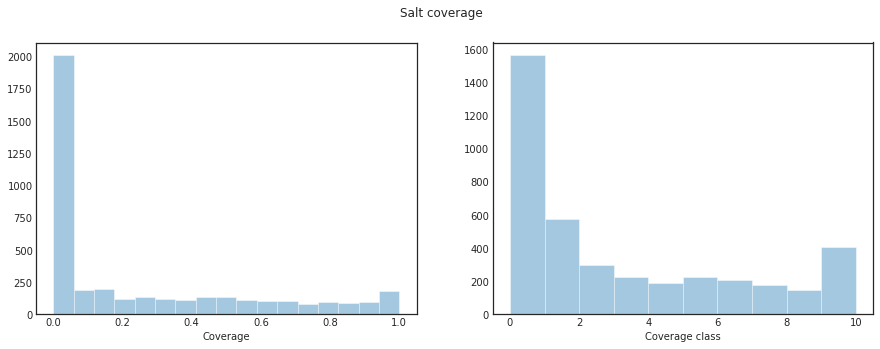

In [9]:
# Plotting the salt coverage distributions
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

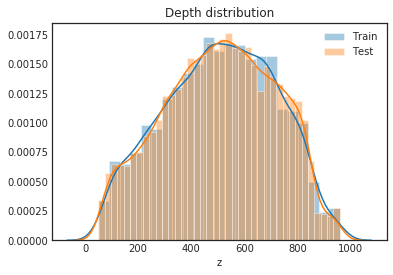

In [10]:
# Plotting the depth distributions
sns.distplot(salt_parser.train_df.z, label="Train")
sns.distplot(salt_parser.test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## 3. Normalize input data to 0-1 range

In [11]:
if normalize:
    # X_train, X_test = utils.normalize_along_channel(X_train, X_test)
    X_train = X_train / 255.
    y_train = y_train / 255.
    X_test = X_test / 255.
    print(f'X_train - min: {np.min(X_train)}, max: {np.max(X_train)}')
    print(f'y_train - min: {np.min(y_train)}, max: {np.max(y_train)}')
    print(f'Train set: {X_train.shape}, {y_train.shape}')
    print(f'X_test - min: {np.min(X_test)}, max: {np.max(X_test)}')
    print(f'Test set: {X_test.shape}'.format())
    
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train - min: 0.0, max: 1.0
y_train - min: 0.0, max: 1.0
Train set: (4000, 101, 101, 1), (4000, 101, 101, 1)
X_test - min: 0.0, max: 1.0
Test set: (18000, 101, 101, 1)


## 4. Perform stratified training/validation split based on coverage.

In [ ]:
# Perform 80/20 training/validation split based on stratified coverage.
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=1234)

del train_df
gc.collect()

del X_train, y_train
gc.collect()

## 5. Define UNet model for training.

Taken from another kernel, thanks!

In [ ]:
from keras import Model
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                          Conv2DTranspose, Dropout, Input, MaxPooling2D,
                          UpSampling2D, concatenate)
from keras.optimizers import Adam


def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n


def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc * dim), depth - 1,
                        inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2,
                                activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m


def UNet(params):

    img_shape = params['input_dim']
    out_ch = 1
    start_ch = 8
    depth = 3
    inc_rate = 2.
    activation = 'relu'
    dropout = 0.5
    batchnorm = False
    maxpool = True
    upconv = True
    residual = False

    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation,
                    dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    # Sigmoid activation is used because model is trained with binary_crossentropy.
    o =  Activation('sigmoid')(o)

    model = Model(inputs=i, outputs=o)
    
    return model

## 6. Train model:

In [ ]:
model = UNet({'input_dim': input_dim})
model.compile(optimizer='adam', loss='binary_crossentropy')


early_stopping = EarlyStopping(monitor='val_loss' ,patience=12, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint("./{}.h5".format(run_name),monitor='val_loss',
                                   save_best_only=True, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

epochs = 10  # change to more for better score!
batch_size = 32


history = model.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

## 7. Predict validation and test set masks:

In [ ]:
y_pred_valid = model.predict(X_val)
y_pred_test = model.predict(X_test)

del X_tr, X_val, X_test
gc.collect()

In [ ]:
# Assume 0.5 threshold for mask binarization.
# This can be optimized!
y_pred_test_rle = salt_parser.predictions_rle_encode(
    y_pred_test, confidence_threshold_best=0.5)

submission = salt_parser.generate_submission(y_pred_test_rle)

# Save submission with specified run_name.
if save:
    submission.to_csv('submission_{}.csv'.format(run_name))
    
submission